In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os as os
import tensorflow as ts
import tensorflow.keras as ks
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Read in Data


In [2]:
# read in data
df = pd.read_csv("./processed_data/pca_data.csv", index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 0 to 477
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cinderella                 478 non-null    float64
 1   Number of Tournament Wins  478 non-null    float64
 2   3pt_0                      478 non-null    float64
 3   Free Throw-Rebound_0       478 non-null    float64
 4   Free Throw-Rebound_1       478 non-null    float64
 5   Free Throw-Rebound_2       478 non-null    float64
 6   Region_0                   478 non-null    float64
 7   PPG_0                      478 non-null    float64
 8   PPG_1                      478 non-null    float64
 9   Scoring Differential_0     478 non-null    float64
 10  Assist_0                   478 non-null    float64
 11  Schedule_0                 478 non-null    float64
 12  Win-Loss_0                 478 non-null    float64
dtypes: float64(13)
memory usage: 52.3 KB


## Create Model

### Neural Network

- Several fully-connected layers
    - Try 256, 128, 64, 32, 7/11

#### Output

##### Win-based

- 7 output nodes, predict number of wins (0-6)
    - Can look at problem as Classification
        - Use `y_dum` for predictions
        - Loss functions:
            - Categorical Cross Entropy: `categorical_crossentropy`
            - KL Divergence: `kl_divergence`
    - Can look at problem as Regression
        - Use `y` for predictions
        - Testing has revealed that this does not work well(?)
- Apply softmax function at end to get probability

##### Rank-based

- Find the optimal ranking of teams for each year
- 11 output nodes, predict which rank (0-10) the team should be placed in


#### Misc Code

- Plot network with `ks.utils.plot_model(model, show_shapes=True)`
- Show summary with `model.summary()`

In [59]:
X = df.drop(columns=['Cinderella','Number of Tournament Wins'])
# y = df[['Cinderella','Number of Tournament Wins']]
y_dum = pd.get_dummies(df['Number of Tournament Wins'])
y = df['Number of Tournament Wins']

In [111]:
# Classification based

model_1 = ks.Sequential()

model_1.add(layers.Input(shape=X.shape[1], name='input'))

model_1.add(layers.Dropout(0.1))

model_1.add(layers.Dense(256, activation='relu6', kernel_regularizer = ks.regularizers.l2(.0001)))

model_1.add(layers.Dropout(0.1))

model_1.add(layers.Dense(128, activation='relu6', kernel_regularizer = ks.regularizers.l2(.0001)))

model_1.add(layers.Dropout(0.05))

model_1.add(layers.Dense(64, activation='relu6', kernel_regularizer = ks.regularizers.l2(.0001)))

model_1.add(layers.Dropout(0.05))

model_1.add(layers.Dense(32, activation='relu6', kernel_regularizer = ks.regularizers.l2(.0001)))

model_1.add(layers.Dense(7, activation='softmax'))


In [112]:
model_1.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
res = model_1.fit(X,y, epochs = 200, batch_size = 32)

Epoch 1/200
15/15 [==============================] - 1s 3ms/step - loss: 1.5925 - accuracy: 0.5126
Epoch 2/200
15/15 [==============================] - 0s 2ms/step - loss: 1.2764 - accuracy: 0.5314
Epoch 3/200
15/15 [==============================] - 0s 2ms/step - loss: 1.1998 - accuracy: 0.5502
Epoch 4/200
15/15 [==============================] - 0s 2ms/step - loss: 1.1745 - accuracy: 0.5586
Epoch 5/200
15/15 [==============================] - 0s 2ms/step - loss: 1.1650 - accuracy: 0.5628
Epoch 6/200
15/15 [==============================] - 0s 2ms/step - loss: 1.1674 - accuracy: 0.5607
Epoch 7/200
15/15 [==============================] - 0s 2ms/step - loss: 1.1231 - accuracy: 0.5628
Epoch 8/200
15/15 [==============================] - 0s 2ms/step - loss: 1.1069 - accuracy: 0.5732
Epoch 9/200
15/15 [==============================] - 0s 2ms/step - loss: 1.0941 - accuracy: 0.5669
Epoch 10/200
15/15 [==============================] - 0s 2ms/step - loss: 1.0957 - accuracy: 0.5879
Epoch 11/

15/15 [==============================] - 0s 2ms/step - loss: 0.6012 - accuracy: 0.7992
Epoch 84/200
15/15 [==============================] - 0s 2ms/step - loss: 0.5387 - accuracy: 0.8389
Epoch 85/200
15/15 [==============================] - 0s 2ms/step - loss: 0.4935 - accuracy: 0.8452
Epoch 86/200
15/15 [==============================] - 0s 2ms/step - loss: 0.5698 - accuracy: 0.7929
Epoch 87/200
15/15 [==============================] - 0s 2ms/step - loss: 0.5570 - accuracy: 0.8054
Epoch 88/200
15/15 [==============================] - 0s 2ms/step - loss: 0.5225 - accuracy: 0.8368
Epoch 89/200
15/15 [==============================] - 0s 2ms/step - loss: 0.5434 - accuracy: 0.8159
Epoch 90/200
15/15 [==============================] - 0s 2ms/step - loss: 0.4754 - accuracy: 0.8598
Epoch 91/200
15/15 [==============================] - 0s 2ms/step - loss: 0.4931 - accuracy: 0.8598
Epoch 92/200
15/15 [==============================] - 0s 2ms/step - loss: 0.5029 - accuracy: 0.8368
Epoch 93/200


15/15 [==============================] - 0s 2ms/step - loss: 0.4584 - accuracy: 0.8556
Epoch 164/200
15/15 [==============================] - 0s 2ms/step - loss: 0.4231 - accuracy: 0.8682
Epoch 165/200
15/15 [==============================] - 0s 2ms/step - loss: 0.4179 - accuracy: 0.8703
Epoch 166/200
15/15 [==============================] - 0s 2ms/step - loss: 0.4518 - accuracy: 0.8619
Epoch 167/200
15/15 [==============================] - 0s 2ms/step - loss: 0.3823 - accuracy: 0.8870
Epoch 168/200
15/15 [==============================] - 0s 2ms/step - loss: 0.4446 - accuracy: 0.8975
Epoch 169/200
15/15 [==============================] - 0s 2ms/step - loss: 0.3607 - accuracy: 0.8933
Epoch 170/200
15/15 [==============================] - 0s 2ms/step - loss: 0.3805 - accuracy: 0.9017
Epoch 171/200
15/15 [==============================] - 0s 2ms/step - loss: 0.3086 - accuracy: 0.9100
Epoch 172/200
15/15 [==============================] - 0s 2ms/step - loss: 0.3707 - accuracy: 0.8870
Epoc

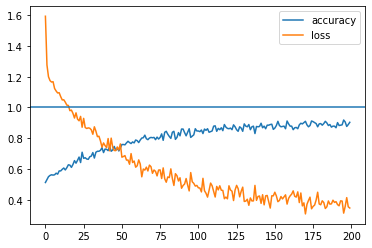

In [113]:
plt.plot(res.epoch, res.history['accuracy'], label='accuracy')
plt.plot(res.epoch, res.history['loss'], label='loss')
# plt.axhline(y=0)
plt.axhline(y=1)
plt.legend()
plt.show()

## Validate Results

- Want to pick several Cinderella teams for bottom 4-6 predictions


## Save Model

- Save model to file along with relevant data